# Read and visualize NSID H5 images (`.h5`) from a folder

This notebook reads **all `.h5` files** in a folder (e.g., `YW_image_h5/`) using:

```python
reader = SciFiReaders.NSIDReader(<file>)
datasets = reader.read()
reader.close()
```

Then it displays the datasets as images.


In [5]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import SciFiReaders

# Folder that contains your NSID-style .h5 files
H5_DIR = Path("YW_image_h5")  # <- change if needed

assert H5_DIR.exists() and H5_DIR.is_dir(), f"Folder not found: {H5_DIR.resolve()}"
print("Using folder:", H5_DIR.resolve())

Using folder: C:\Users\wongu\Desktop\hackerthon\.venv\Microscopy_Hackathon\notebooks\AFM\temp\YW_image_h5


In [6]:
# List all .h5 files
h5_files = sorted(H5_DIR.glob("*.h5"))
print("Found", len(h5_files), "files")
h5_files[:10]

Found 6 files


[WindowsPath('YW_image_h5/Graphite.h5'),
 WindowsPath('YW_image_h5/Li-Cu-Si.h5'),
 WindowsPath('YW_image_h5/SiO15(2).h5'),
 WindowsPath('YW_image_h5/SiO15.h5'),
 WindowsPath('YW_image_h5/StainlessSteel.h5'),
 WindowsPath('YW_image_h5/TG3D-3000-20.h5')]

Found 6 h5 files in C:\Users\wongu\Desktop\hackerthon\.venv\Microscopy_Hackathon\notebooks\AFM\temp\YW_image_h5_converted


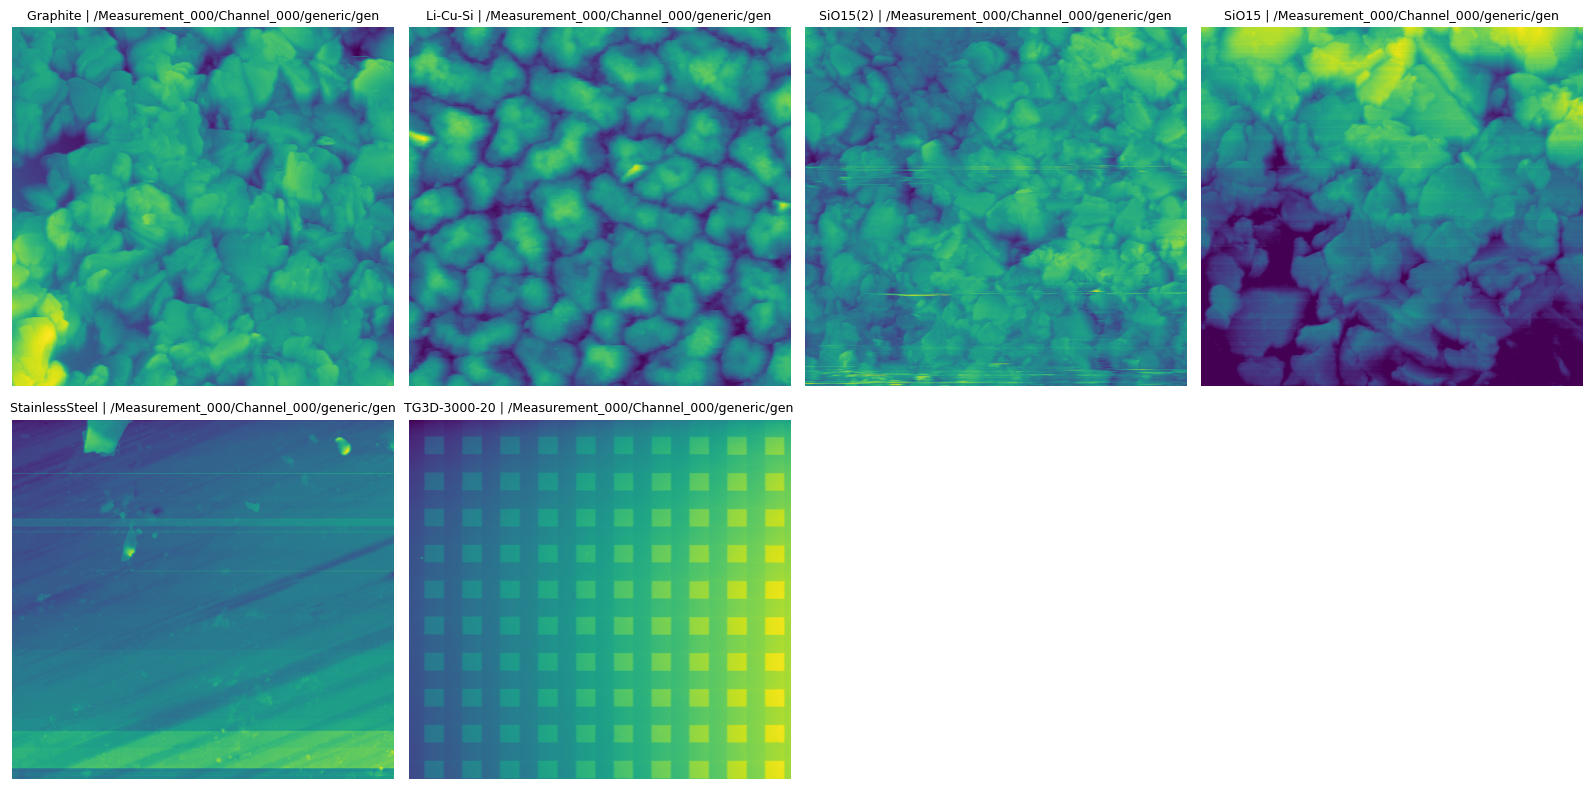

In [7]:
def to_list(datasets):
    if isinstance(datasets, dict):
        return [datasets[k] for k in sorted(datasets.keys())]
    if isinstance(datasets, (list, tuple)):
        return list(datasets)
    return [datasets]


def read_h5_folder_show_images(folder_name: str, max_files=24, cols=4, max_datasets_per_file=1):
    folder = Path(folder_name)
    assert folder.exists() and folder.is_dir(), f"Folder not found: {folder.resolve()}"

    h5_files = sorted(folder.glob("*.h5"))
    if max_files is not None:
        h5_files = h5_files[:max_files]

    print("Found", len(h5_files), "h5 files in", folder.resolve())
    if not h5_files:
        return

    images, titles = [], []

    for fp in h5_files:
        try:
            reader = SciFiReaders.NSIDReader(str(fp))
            datasets = reader.read()
            reader.close()

            ds_list = to_list(datasets)

            shown = 0
            for j, ds in enumerate(ds_list):
                arr = np.array(ds)
                name = getattr(ds, "title", None) or getattr(ds, "name", None) or f"dataset_{j}"

                if arr.ndim == 2:
                    images.append(arr)
                    titles.append(f"{fp.stem} | {str(name)[:40]}")
                    shown += 1
                elif arr.ndim > 2:
                    sl = tuple(s//2 for s in arr.shape[:-2]) + (slice(None), slice(None))
                    images.append(arr[sl])
                    titles.append(f"{fp.stem} | {str(name)[:40]} (slice)")
                    shown += 1

                if max_datasets_per_file is not None and shown >= max_datasets_per_file:
                    break

        except Exception as e:
            print(f"[FAIL] {fp.name}: {type(e).__name__}: {e}")

    if not images:
        print("No displayable images were loaded.")
        return

    n = len(images)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, (img, title) in enumerate(zip(images, titles), start=1):
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img, aspect="auto")
        ax.set_title(title, fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Example:
read_h5_folder_show_images("YW_image_h5_converted", max_files=24, cols=4, max_datasets_per_file=1)